In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import re

__Loading__ the data.

In [2]:
path = 'complete_data_with_vader.csv'
df = pd.read_csv(path)
df_tweet = df[['id_str', 'user_id_str', 'entity_user_mentions', 'tweet_created_at', 'Vader_neg', 'Vader_neu',\
                     'Vader_pos', 'Vader_com']]

__Preprocessing__ the data.

In [26]:
#Finding tweets where airlines are mentioned
#KLM is 0, Lufthansa is 4
airline_list = ['56377143','106062176','18332190','22536055','124476322','26223583','2182373406','38676903','1542862735',\
                '253340062','218730857','45621423','20626359']
airline_names = ['KLM', 'AirFrance', 'British_Airways', 'AmericanAir', 'Lufthansa', 'AirBerlin', 'Airberlin_assist',\
                 'easyJet', 'RyanAir', 'SingaporeanAir', 'Qantas', 'EtihadAirways', 'VirginAtlantic'] #zip together

df_tweet['entity_user_mentions'].astype(str)
df_tweet['id_str'].astype(str)
df_tweet['user_id_str'].astype(str)
df_tweet['entity_user_mention_id'] = [re.findall(r"\'(\d+)\'", str(n)) for n in df_tweet['entity_user_mentions']]

C:\Users\20223084\AppData\Local\Temp\ipykernel_8656\3365472032.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweet['entity_user_mention_id'] = [re.findall(r"\'(\d+)\'", str(n)) for n in df_tweet['entity_user_mentions']]


In [27]:
#Finding all user tweets where airlines are mentioned
#Removing Tweets w/o VADER scores - other languages 
df_airline = df_tweet.copy()
df_airline['entity_user_mention_id'] = df_tweet['entity_user_mention_id'].apply(lambda x: \
                                                                                  list(set(x).intersection(set(airline_list))))

#Remove airlines' OG tweets, tweets with no mentions, and tweets w/o SA scores
df_airline.drop(df_airline[df_airline['user_id_str'].isin(airline_list)].index, inplace = True)
df_airline = df_airline[df_airline.astype(str)['entity_user_mention_id'] != '[]']
df_airline = df_airline[~df_airline['Vader_com'].isna()]

In [28]:
#make columns to differentiate between airlines in graphs
other_airlines = ['106062176','18332190','22536055','26223583','2182373406','38676903','1542862735', \
                  '253340062','218730857','45621423','20626359']

df_airline['LH_mention'] = df_airline['entity_user_mention_id'].apply(lambda x:'56377143' in x)
df_airline['KLM_mention'] = df_airline['entity_user_mention_id'].apply(lambda x:'124476322' in x)
df_airline['rest_mention'] = [set(x).issubset(other_airlines) for x in df_airline['entity_user_mention_id']]

In [29]:
# #making time columns for graphs
df_airline['year'] = pd.DatetimeIndex(df_airline['tweet_created_at']).year
df_airline['month'] = pd.DatetimeIndex(df_airline['tweet_created_at']).month
df_airline['day'] = pd.DatetimeIndex(df_airline['tweet_created_at']).day
df_airline['time'] = pd.DatetimeIndex(df_airline['tweet_created_at']).time

df_airline.head(3)

,id_str,user_id_str,entity_user_mentions,tweet_created_at,Vader_neg,Vader_neu,Vader_pos,Vader_com,entity_user_mention_id,LH_mention,KLM_mention,rest_mention,year,month,day,time
6,1.244180e+18,106864306,"('ARCHANGELTY', '1025395291938344960'),('easyJ...",2020-03-29 08:29:38+00:00,0.078,0.922,0.000,-0.2144,[38676903],False,False,True,2020,3,29,08:29:38
12,1.244180e+18,1221885921064255489,"('SolihullUHB', '1008729066080489472'),('Briti...",2020-03-29 08:29:55+00:00,0.000,0.590,0.410,0.9022,[18332190],False,False,True,2020,3,29,08:29:55
16,1.244180e+18,2758345674,"('lufthansa', '124476322'),('AirCanada', '5490...",2020-03-29 08:30:21+00:00,0.000,0.865,0.135,0.4215,[124476322],False,True,False,2020,3,29,08:30:21


## Visualizations

First we look at overall sentiment for __all airlines.__

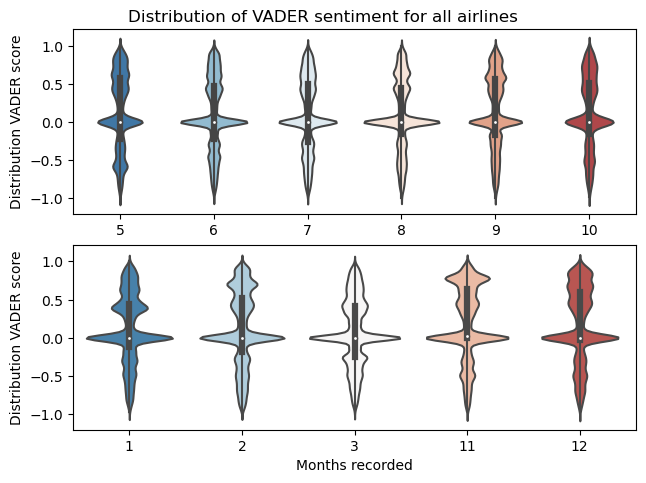

In [30]:
#Distribution of VADER sentiment for all airlines
df1 = df_airline[df_airline['month'].isin([5,6,7,8,9,10])]
df2 = df_airline[df_airline['month'].isin([11,12,1,2,3])]

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True)#, figsize=(20,10))

sns.violinplot(data=df1, x="month", y="Vader_com", palette='RdBu_r', ax=ax[0])#, figsize=(20,25))
sns.violinplot(data=df2, x="month", y="Vader_com", palette='RdBu_r', ax=ax[1])#, figsize=(20,25))

fig.suptitle('Distribution of VADER sentiment for all airlines')

ax[0].set(xlabel=None)

ax[0].set_ylabel('Distribution VADER score')
ax[1].set_ylabel('Distribution VADER score')
ax[1].set_xlabel('Months recorded')

fig.tight_layout(pad=0.5);

#SAVE:
# fig.savefig("VS distr_all airlines.png")

Next we look at __Lufthansa__ sentiment visualizations.

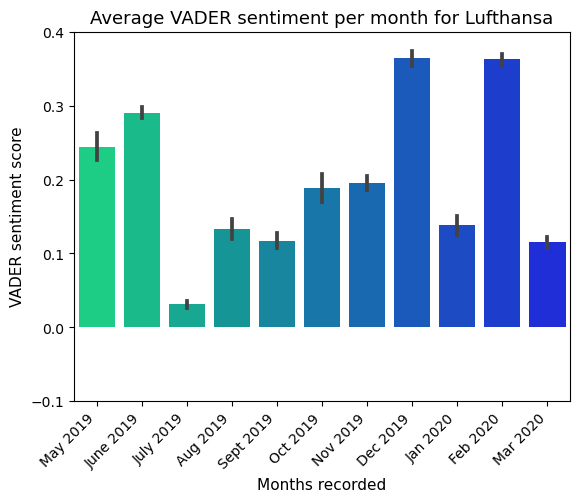

In [31]:
#average VADER sentiment per month for Lufthansa
df_lh = df_airline[df_airline['LH_mention'] ==True]
lh_mean = sns.barplot(data=df_lh, x="month", y="Vader_com", palette='winter_r', order=[5,6,7,8,9,10,11,12,1,2,3]);
lh_mean.set_xlabel("Months recorded", size=11)
lh_mean.set_ylabel('VADER sentiment score', size=11)
lh_mean.set_title('Average VADER sentiment per month for Lufthansa', size=13);
lh_mean.set_ylim(-0.1, 0.4);

lh_mean.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
lh_mean.set_xticklabels(["May 2019", 'June 2019', "July 2019", "Aug 2019", "Sept 2019", "Oct 2019", \
                             "Nov 2019", "Dec 2019", "Jan 2020", "Feb 2020", "Mar 2020"], rotation = 45, ha="right");

# #SAVE:
# plt.savefig("VS monthly mean bars_Lufthansa.png", bbox_inches="tight")

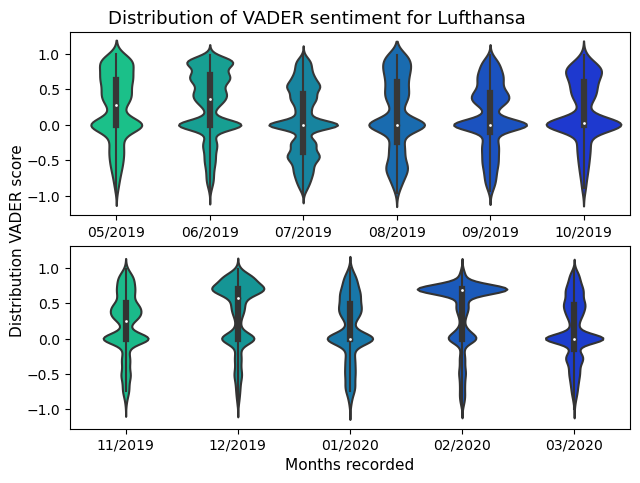

In [32]:
#Distribution of VADER sentiment for Lufthansa
df1_lh = df_lh[df_lh['month'].isin([5,6,7,8,9,10])]
df2_lh = df_lh[df_lh['month'].isin([11,12,1,2,3])]

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True)

sns.violinplot(data=df1_lh, x="month", y="Vader_com", palette='winter_r', ax=ax[0])
sns.violinplot(data=df2_lh, x="month", y="Vader_com", palette='winter_r', ax=ax[1], order=[11,12,1,2,3])

fig.suptitle('Distribution of VADER sentiment for Lufthansa', size=13)
fig.supylabel('Distribution VADER score', size=11)

ax[0].set(xlabel=None, ylabel=None)
ax[1].set(ylabel=None)

ax[1].set_xlabel('Months recorded', size=11)

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(["05/2019", '06/2019', "07/2019", "08/2019", "09/2019", "10/2019"])

ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xticklabels(["11/2019", '12/2019', "01/2020", "02/2020", "03/2020"])

fig.tight_layout(pad=0.5);

# #SAVE:
# fig.savefig("VS distr_Lufthansa.png", bbox_inches="tight")

Then we look at __KLM__ sentiment visualizations.

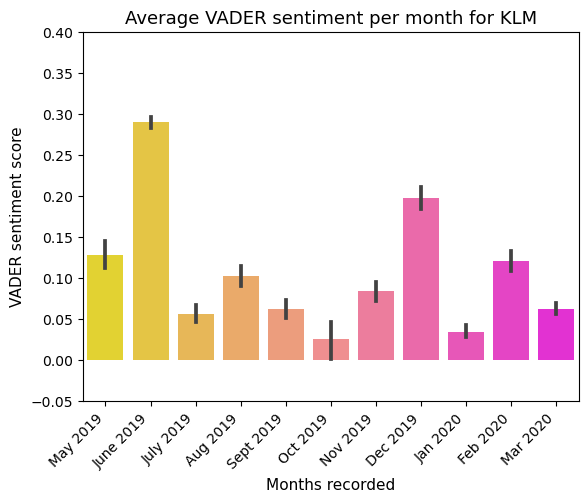

In [34]:
#Average VADER sentiment per month for KLM
df_klm = df_airline[df_airline['KLM_mention'] ==True]
klm_mean = sns.barplot(data=df_klm, x="month", y="Vader_com", palette='spring_r', order=[5,6,7,8,9,10,11,12,1,2,3]);
klm_mean.set_xlabel("Months recorded", size=11)
klm_mean.set_ylabel('VADER sentiment score', size=11)
klm_mean.set_title('Average VADER sentiment per month for KLM', size=13);
klm_mean.set_ylim(-0.05, 0.4);

klm_mean.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
klm_mean.set_xticklabels(["May 2019", 'June 2019', "July 2019", "Aug 2019", "Sept 2019", "Oct 2019", \
                             "Nov 2019", "Dec 2019", "Jan 2020", "Feb 2020", "Mar 2020"], rotation = 45, ha="right");

# #SAVE:
# plt.savefig("VS monthly mean bars_KLM.png", bbox_inches="tight")

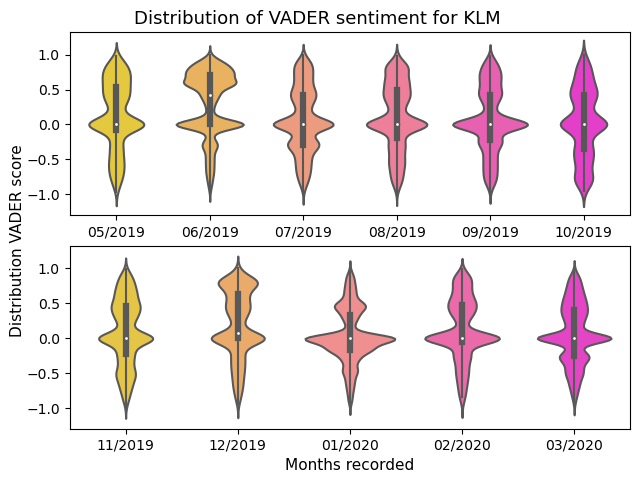

In [35]:
#Distribution of VADER sentiment for all KLM
df1_klm = df_klm[df_klm['month'].isin([5,6,7,8,9,10])]
df2_klm = df_klm[df_klm['month'].isin([11,12,1,2,3])]

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True)

sns.violinplot(data=df1_klm, x="month", y="Vader_com", palette='spring_r', ax=ax[0])
sns.violinplot(data=df2_klm, x="month", y="Vader_com", palette='spring_r', ax=ax[1], order=[11,12,1,2,3])

fig.suptitle('Distribution of VADER sentiment for KLM', size=13)
fig.supylabel('Distribution VADER score', size=11)

ax[0].set(xlabel=None, ylabel=None)
ax[1].set(ylabel=None)

ax[1].set_xlabel('Months recorded', size=11)

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(["05/2019", '06/2019', "07/2019", "08/2019", "09/2019", "10/2019"])

ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xticklabels(["11/2019", '12/2019', "01/2020", "02/2020", "03/2020"])

fig.tight_layout(pad=0.5);

# #SAVE:
# fig.savefig("VS distr_KLM.png", bbox_inches="tight")

Lastly, a few summarizing graphs.

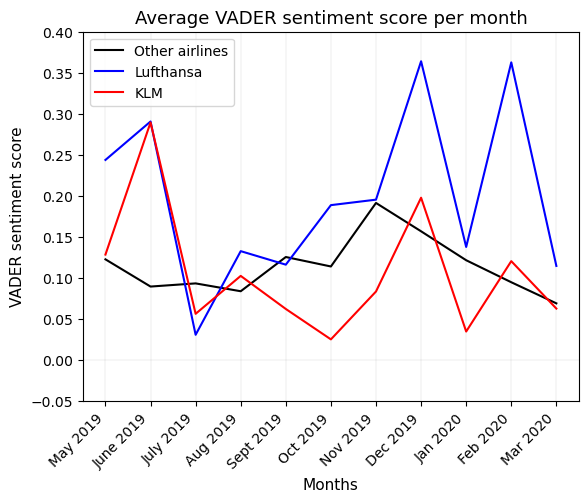

In [36]:
#line graph with monthly sentiment changes
ax_combined = df_rest.groupby(['year', 'month'])['Vader_com'].mean().plot(color='k')
df_lh.groupby(['year', 'month'])['Vader_com'].mean().plot(color='b', ax=ax_combined)
df_klm.groupby(['year', 'month'])['Vader_com'].mean().plot(color='r', ax=ax_combined)
# df_rest.groupby(['year', 'month'])['Vader_com'].mean().plot(color='purple', ax=ax_combined)

ax_combined.set_ylim(-0.05, 0.4)
ax_combined.set_xlabel("Months", size=11)
ax_combined.set_ylabel("VADER sentiment score", size=11)
ax_combined.set_title("Average VADER sentiment score per month", size=13)
ax_combined.legend(["Other airlines", "Lufthansa", "KLM"])#, "Other airlines"])
ax_combined.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax_combined.set_xticklabels(["May 2019", 'June 2019', "July 2019", "Aug 2019", "Sept 2019", "Oct 2019", \
                             "Nov 2019", "Dec 2019", "Jan 2020", "Feb 2020", "Mar 2020"], rotation = 45, ha="right")
plt.axhline(y = 0, color='gray', linewidth=0.1)
plt.grid(axis = 'x', color='gray', linewidth=0.1);

# data_grouped = df_airline.groupby(['month', 'day']).mean()
# data_matrix = data_grouped['Vader_com'].unstack()
# sns.heatmap(data=data_matrix, square=True);

# #SAVE:
# plt.savefig("VS mean lines_all.png", bbox_inches="tight")

In [37]:
#average sentiment per airline table
df_airline['entity_user_mention_id'] = [n[0] for n in df_airline['entity_user_mention_id']]
df_airline['entity_user_mention_id'] = df_airline['entity_user_mention_id'].astype(str)
dict_mention = dict(zip(airline_list, airline_names))
df_mention = df_airline.groupby(['entity_user_mention_id'], as_index=False)['Vader_com'].mean().copy()

In [38]:
df_try = df_mention.copy()
df_try['entity_user_mention_id'].astype(str)
df_try["entity_user_mention_id"] = df_try["entity_user_mention_id"].map(dict_mention)
df_try

,entity_user_mention_id,Vader_com
0,AirFrance,0.070201
1,Lufthansa,0.132241
2,RyanAir,0.058756
3,British_Airways,0.112476
4,VirginAtlantic,0.290076
5,Qantas,0.091873
6,AmericanAir,0.059302
7,SingaporeanAir,0.390323
8,AirBerlin,0.093283
9,easyJet,0.068115


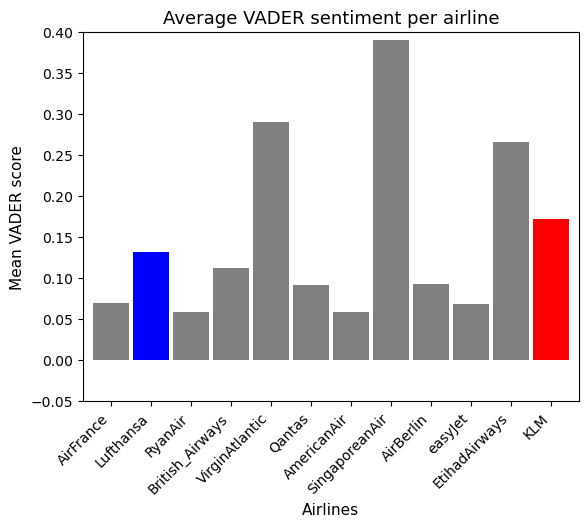

In [39]:
mention_mean = df_try.plot(kind='bar', x='entity_user_mention_id', y='Vader_com', width=0.9, \
                           color=['gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'red'])

mention_mean.set_title('Average VADER sentiment per airline', size=13);
mention_mean.set_xlabel('Airlines', size=11)
mention_mean.set_ylabel('Mean VADER score', size=11)
mention_mean.set_ylim(-0.05, 0.4)
plt.legend('', frameon=False)

mention_mean.set_xticklabels(df_try['entity_user_mention_id'], rotation = 45, ha="right");

plt.savefig("average VS per airline.png", bbox_inches="tight")

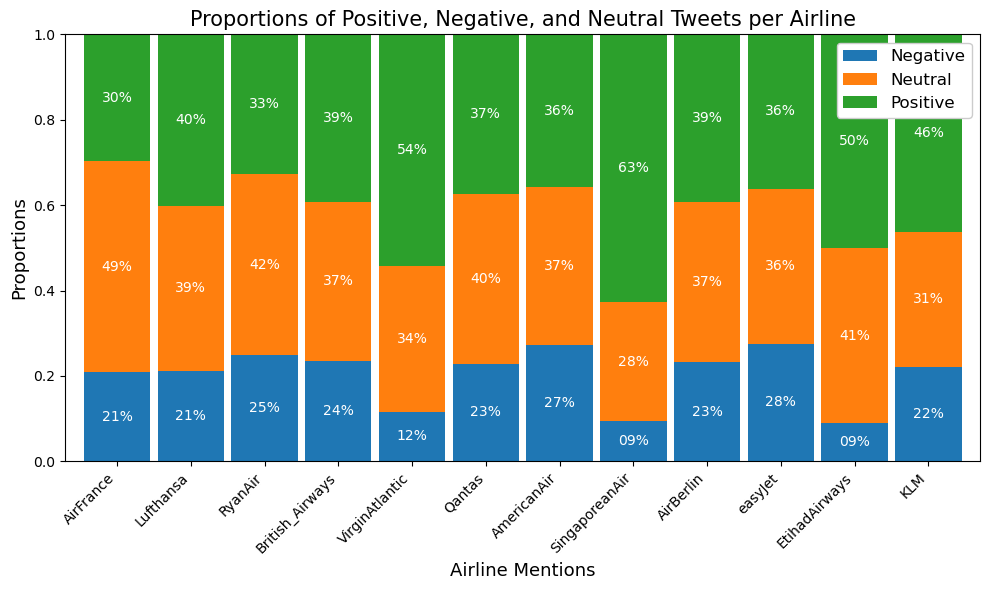

In [40]:
# Calculate proportions per airline
df_airline['sentiment_category'] = pd.cut(df_airline['Vader_com'], bins=[-1, -0.25, 0.25, 1], labels=['Negative', 'Neutral', 'Positive'])
df_proportions = df_airline.groupby(['entity_user_mention_id', 'sentiment_category']).size().unstack().reset_index()
df_proportions['Total'] = df_proportions[['Negative', 'Neutral', 'Positive']].sum(axis=1)
df_proportions['Negative'] /= df_proportions['Total']
df_proportions['Neutral'] /= df_proportions['Total']
df_proportions['Positive'] /= df_proportions['Total']

# Getting airline names from dictionary
df_proportions['entity_user_mention_id'] = df_proportions['entity_user_mention_id'].map(dict_mention)

# Plotting 
mention_proportions = df_proportions.plot(kind='bar', x='entity_user_mention_id', y=['Negative', 'Neutral', 'Positive'], stacked=True, width=0.9, figsize=(10, 6))
mention_proportions.set_title('Proportions of Positive, Negative, and Neutral Tweets per Airline', size=15)
mention_proportions.set_xlabel('Airline Mentions', size=13)
mention_proportions.set_ylabel('Proportions', size=13)
mention_proportions.set_ylim(0, 1)
mention_proportions.legend(['Negative', 'Neutral', 'Positive'], loc='upper right', frameon=False)
plt.legend(facecolor='white', framealpha=1, prop={'size': 12})

#add percentages on bars
for c in mention_proportions.containers:
    labels = ['{:.2f}'.format(round(v.get_height(), 2))[2:] + "%" if v.get_height() > 0 else '' for v in c]
    mention_proportions.bar_label(c, labels=labels, label_type='center', color='white', size=10)

mention_proportions.set_xticklabels(mention_proportions.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

plt.savefig("Proportions stacked bar chart.png", bbox_inches="tight")

We still need something for:
- word frequency (categories, sentiments, count)

Other suggestions were:
- total tweets posted with mean sentiment per month
- total tweets answered with mean sentiment per month